# **Assignment 3 - RNN - Weather Time Series Forcasting**

# **Name: Rishitha Reddy Muddasani**

# **Date: 11-04-2023**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-06 01:35:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.41.192, 52.217.206.176, 52.217.130.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.41.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  34.4MB/s    in 0.4s    

2023-11-06 01:35:44 (34.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

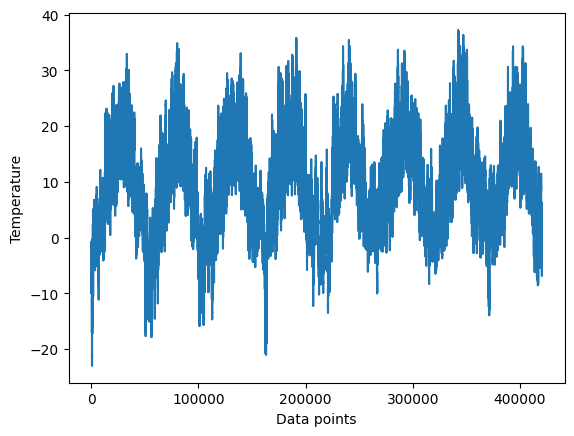

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

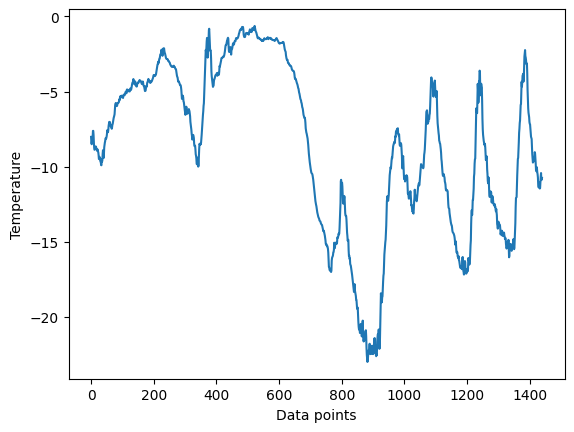

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **A common-sense, non-machine-learning baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Predicting that the temperature in the next 24 hours will be the same as the current temperature is a common-sense baseline approach. The test MAE is 2.62 degrees Celsius, whereas the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius using the straightforward baseline. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **A basic machine-learning model - Dense Layer**

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [ ]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 67s 80ms/step - loss: 14.7115 - mae: 2.9633 - val_loss: 13.2832 - val_mae: 2.8858
Epoch 2/10
819/819 [==============================] - 61s 74ms/step - loss: 10.3703 - mae: 2.5357 - val_loss: 11.3453 - val_mae: 2.6680
Epoch 3/10
819/819 [==============================] - 58s 70ms/step - loss: 9.4670 - mae: 2.4212 - val_loss: 11.2393 - val_mae: 2.6512
Epoch 4/10
819/819 [==============================] - 60s 73ms/step - loss: 8.9176 - mae: 2.3499 - val_loss: 10.7934 - val_mae: 2.6115
Epoch 5/10
819/819 [==============================] - 83s 101ms/step - loss: 8.4887 - mae: 2.2936 - val_loss: 10.6658 - val_mae: 2.5923
Epoch 6/10
819/819 [==============================] - 59s 72ms/step - loss: 8.1711 - mae: 2.2503 - val_loss: 11.0346 - val_mae: 2.6305
Epoch 7/10
819/819 [==============================] - 60s 73ms/step - loss: 7.9651 - mae: 2.2221 - val_loss: 11.1659 - val_mae: 2.6455
Epoch 8/10
819/819 [==============================] 

In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 20s 47ms/step - loss: 11.8412 - mae: 2.6974
Test MAE: 2.70


**Plotting results**

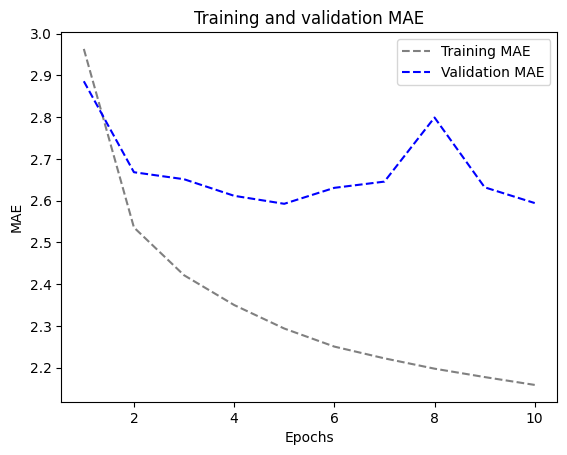

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **Let's try a 1D convolutional model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 105s 127ms/step - loss: 23.2817 - mae: 3.7661 - val_loss: 19.6087 - val_mae: 3.5522
Epoch 2/10
819/819 [==============================] - 123s 149ms/step - loss: 15.5978 - mae: 3.1397 - val_loss: 15.6046 - val_mae: 3.1376
Epoch 3/10
819/819 [==============================] - 104s 126ms/step - loss: 14.5558 - mae: 3.0292 - val_loss: 16.5264 - val_mae: 3.1843
Epoch 4/10
819/819 [==============================] - 121s 147ms/step - loss: 13.8183 - mae: 2.9495 - val_loss: 16.9872 - val_mae: 3.2783
Epoch 5/10
819/819 [==============================] - 105s 128ms/step - loss: 13.2594 - mae: 2.8877 - val_loss: 19.9089 - val_mae: 3.5135
Epoch 6/10
819/819 [==============================] - 119s 145ms/step - loss: 12.7896 - mae: 2.8350 - val_loss: 16.6576 - val_mae: 3.2347
Epoch 7/10
819/819 [==============================] - 106s 129ms/step - loss: 12.2819 - mae: 2.7765 - val_loss: 18.2817 - val_mae: 3.3788
Epoch 8/10
819/819 [==============

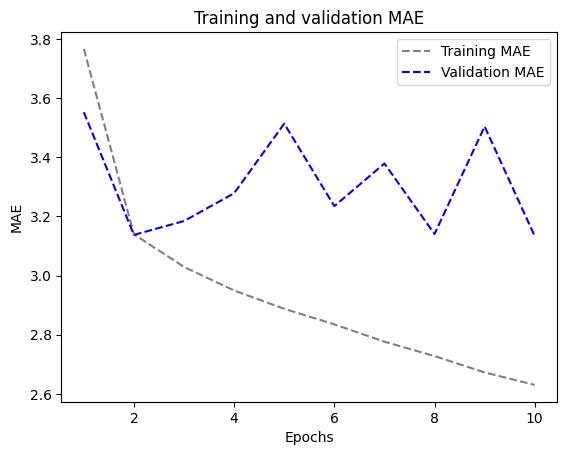

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

*It seems that the convolutional data performed poor compared to common sense or dense model. This could be because*

*- The assumption of translation invariance does not hold well for weather data.*

*- The order of the data is crucial. Recent past data is significantly more informative for predicting the temperature of the following day compared to data from several days ago. Unfortunately, a 1D convolutional neural network is unable to effectively capture this critical temporal order.*






## **A Simple RNN**

### **1.An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 107s 129ms/step - loss: 138.5179 - mae: 9.6867 - val_loss: 143.9931 - val_mae: 9.9053
Epoch 2/10
819/819 [==============================] - 86s 104ms/step - loss: 136.4646 - mae: 9.5680 - val_loss: 143.7886 - val_mae: 9.8844
Epoch 3/10
819/819 [==============================] - 103s 126ms/step - loss: 136.2787 - mae: 9.5489 - val_loss: 143.5958 - val_mae: 9.8568
Epoch 4/10
819/819 [==============================] - 82s 100ms/step - loss: 136.1890 - mae: 9.5398 - val_loss: 143.5571 - val_mae: 9.8513
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 136.1360 - mae: 9.5338 - val_loss: 143.5160 - val_mae: 9.8462
Epoch 6/10
819/819 [==============================] - 83s 101ms/step - loss: 136.0992 - mae: 9.5301 - val_loss: 143.5118 - val_mae: 9.8485
Epoch 7/10
819/819 [==============================] - 104s 127ms/step - loss: 136.0931 - mae: 9.5297 - val_loss: 143.5110 - val_mae: 9.8449
Epoch 8/10
819/819 [===

### **2.Simple RNN - Stacking RNN layers**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 165s 201ms/step - loss: 135.9003 - mae: 9.5062 - val_loss: 143.4482 - val_mae: 9.8395
Epoch 3/10
819/819 [==============================] - 175s 213ms/step - loss: 135.8786 - mae: 9.5027 - val_loss: 143.4912 - val_mae: 9.8448
Epoch 4/10
819/819 [==============================] - 168s 204ms/step - loss: 135.8529 - mae: 9.4983 - val_loss: 143.4105 - val_mae: 9.8329
Epoch 5/10
819/819 [==============================] - 165s 201ms/step - loss: 135.8384 - mae: 9.4958 - val_loss: 143.3881 - val_mae: 9.8301
Epoch 6/10
819/819 [==============================] - 164s 200ms/step - loss: 135.8224 - mae: 9.4934 - val_loss: 143.4176 - val_mae: 9.8331
Epoch 7/10
819/819 [==============================] - 165s 200ms/step - loss: 135.8168 - mae: 9.4923 - val_loss: 143.4189 - val_mae: 9.8341
Epoch 8/10
819/819 [==============================] - 165s 202ms/step - loss: 135.8069 - mae: 9.4901 - val_loss: 143.4197 - val_mae: 9.8331
Epoch 9/10
819/819 [

## **A Simple GRU (Gated Recurrent Unit)**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 133s 159ms/step - loss: 36.7208 - mae: 4.3977 - val_loss: 12.3041 - val_mae: 2.6524
Epoch 2/10
819/819 [==============================] - 130s 158ms/step - loss: 10.6372 - mae: 2.5431 - val_loss: 10.2886 - val_mae: 2.4566
Epoch 3/10
819/819 [==============================] - 146s 178ms/step - loss: 9.8971 - mae: 2.4563 - val_loss: 9.7865 - val_mae: 2.4124
Epoch 4/10
819/819 [==============================] - 133s 162ms/step - loss: 9.5849 - mae: 2.4176 - val_loss: 10.4387 - val_mae: 2.4702
Epoch 5/10
819/819 [==============================] - 129s 157ms/step - loss: 9.2760 - mae: 2.3814 - val_loss: 9.0992 - val_mae: 2.3329
Epoch 6/10
819/819 [==============================] - 147s 179ms/step - loss: 9.0221 - mae: 2.3507 - val_loss: 9.7932 - val_mae: 2.4062
Epoch 7/10
819/819 [==============================] - 129s 157ms/step - loss: 8.8293 - mae: 2.3276 - val_loss: 9.5328 - val_mae: 2.3750
Epoch 8/10
819/819 [=======================

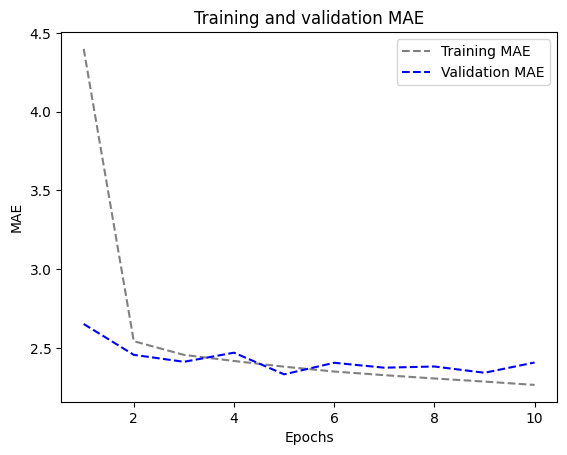

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory )**

### **1.LSTM-Simple**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 147s 174ms/step - loss: 35.0201 - mae: 4.2900 - val_loss: 11.6325 - val_mae: 2.6398
Epoch 2/10
819/819 [==============================] - 130s 158ms/step - loss: 10.9248 - mae: 2.5720 - val_loss: 9.7855 - val_mae: 2.4326
Epoch 3/10
819/819 [==============================] - 146s 177ms/step - loss: 9.8926 - mae: 2.4503 - val_loss: 9.8032 - val_mae: 2.4297
Epoch 4/10
819/819 [==============================] - 133s 161ms/step - loss: 9.3780 - mae: 2.3829 - val_loss: 10.0179 - val_mae: 2.4405
Epoch 5/10
819/819 [==============================] - 132s 160ms/step - loss: 9.0035 - mae: 2.3363 - val_loss: 10.1349 - val_mae: 2.4454
Epoch 6/10
819/819 [==============================] - 131s 160ms/step - loss: 8.6749 - mae: 2.2995 - val_loss: 10.1267 - val_mae: 2.4489
Epoch 7/10
819/819 [==============================] - 132s 160ms/step - loss: 8.3790 - mae: 2.2593 - val_loss: 10.1359 - val_mae: 2.4429
Epoch 8/10
819/819 [=====================

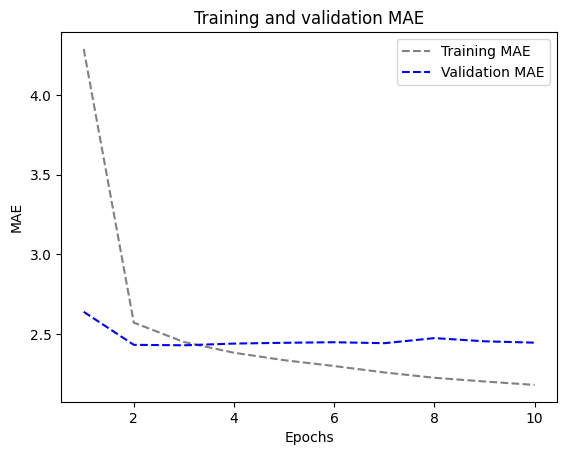

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **2.LSTM - dropout Regularization**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 221s 266ms/step - loss: 49.5495 - mae: 5.2562 - val_loss: 13.9964 - val_mae: 2.8213
Epoch 2/10
819/819 [==============================] - 218s 266ms/step - loss: 20.0943 - mae: 3.4495 - val_loss: 9.9902 - val_mae: 2.4535
Epoch 3/10
819/819 [==============================] - 205s 250ms/step - loss: 18.2062 - mae: 3.2823 - val_loss: 9.5961 - val_mae: 2.4094
Epoch 4/10
819/819 [==============================] - 207s 251ms/step - loss: 17.3290 - mae: 3.2019 - val_loss: 9.5724 - val_mae: 2.4202
Epoch 5/10
819/819 [==============================] - 216s 264ms/step - loss: 16.7767 - mae: 3.1526 - val_loss: 9.3860 - val_mae: 2.3869
Epoch 6/10
819/819 [==============================] - 216s 264ms/step - loss: 16.2062 - mae: 3.0947 - val_loss: 9.1209 - val_mae: 2.3544
Epoch 7/10
819/819 [==============================] - 216s 263ms/step - loss: 15.8028 - mae: 3.0580 - val_loss: 9.1747 - val_mae: 2.3539
Epoch 8/10
819/819 [====================

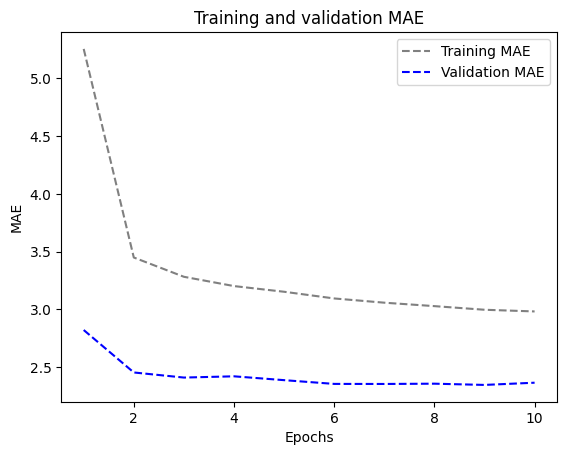

In [28]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **3.LSTM - Stacked setup with 16 units**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 230s 266ms/step - loss: 37.1632 - mae: 4.4030 - val_loss: 11.8254 - val_mae: 2.5999
Epoch 2/10
819/819 [==============================] - 257s 313ms/step - loss: 10.1580 - mae: 2.4663 - val_loss: 9.4424 - val_mae: 2.3655
Epoch 3/10
819/819 [==============================] - 216s 263ms/step - loss: 8.9192 - mae: 2.3218 - val_loss: 9.7727 - val_mae: 2.4251
Epoch 4/10
819/819 [==============================] - 256s 312ms/step - loss: 8.3345 - mae: 2.2456 - val_loss: 9.5263 - val_mae: 2.4163
Epoch 5/10
819/819 [==============================] - 214s 261ms/step - loss: 7.9126 - mae: 2.1883 - val_loss: 9.7197 - val_mae: 2.4387
Epoch 6/10
819/819 [==============================] - 215s 262ms/step - loss: 7.5245 - mae: 2.1359 - val_loss: 9.4815 - val_mae: 2.4101
Epoch 7/10
819/819 [==============================] - 214s 260ms/step - loss: 7.2186 - mae: 2.0945 - val_loss: 9.9520 - val_mae: 2.4726
Epoch 8/10
819/819 [=========================

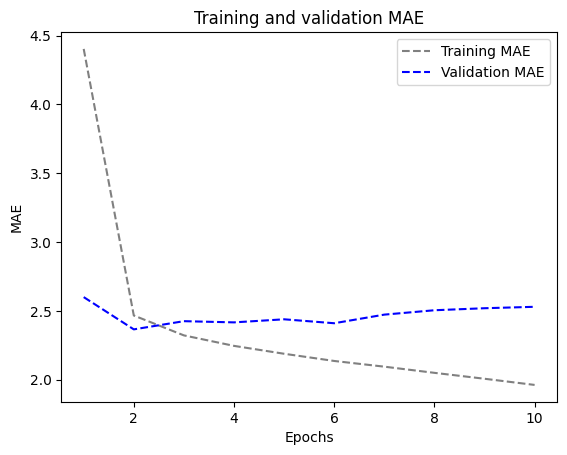

In [30]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 32 units**

In [31]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 345s 415ms/step - loss: 21.7611 - mae: 3.3300 - val_loss: 10.4087 - val_mae: 2.5153
Epoch 2/10
819/819 [==============================] - 342s 417ms/step - loss: 7.9112 - mae: 2.1910 - val_loss: 10.3949 - val_mae: 2.5206
Epoch 3/10
819/819 [==============================] - 335s 408ms/step - loss: 6.3478 - mae: 1.9551 - val_loss: 11.2475 - val_mae: 2.6150
Epoch 4/10
819/819 [==============================] - 319s 389ms/step - loss: 5.3298 - mae: 1.7856 - val_loss: 12.2745 - val_mae: 2.7523
Epoch 5/10
819/819 [==============================] - 339s 414ms/step - loss: 4.5446 - mae: 1.6447 - val_loss: 13.1959 - val_mae: 2.8538
Epoch 6/10
819/819 [==============================] - 340s 415ms/step - loss: 3.9282 - mae: 1.5269 - val_loss: 13.1486 - val_mae: 2.8673
Epoch 7/10
819/819 [==============================] - 339s 413ms/step - loss: 3.4640 - mae: 1.4292 - val_loss: 13.7760 - val_mae: 2.9213
Epoch 8/10
819/819 [====================

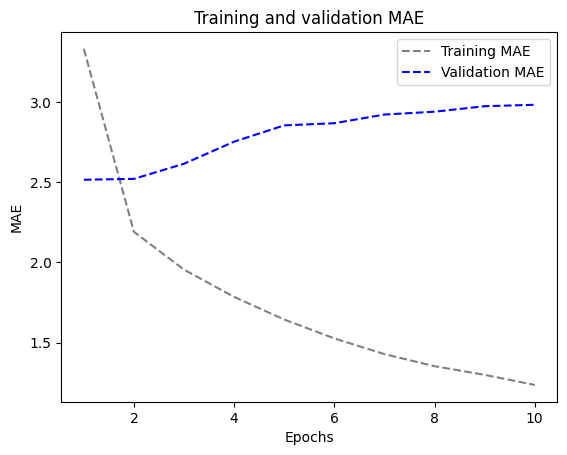

In [32]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **4.LSTM - Stacked setup with 8 units**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 196s 234ms/step - loss: 58.9197 - mae: 5.8048 - val_loss: 28.3691 - val_mae: 3.9426
Epoch 2/10
819/819 [==============================] - 184s 225ms/step - loss: 17.9717 - mae: 3.1698 - val_loss: 11.7874 - val_mae: 2.6216
Epoch 3/10
819/819 [==============================] - 182s 222ms/step - loss: 10.8825 - mae: 2.5687 - val_loss: 9.9408 - val_mae: 2.4611
Epoch 4/10
819/819 [==============================] - 190s 232ms/step - loss: 9.9738 - mae: 2.4695 - val_loss: 9.5254 - val_mae: 2.4071
Epoch 5/10
819/819 [==============================] - 180s 219ms/step - loss: 9.6800 - mae: 2.4322 - val_loss: 9.3291 - val_mae: 2.3781
Epoch 6/10
819/819 [==============================] - 189s 230ms/step - loss: 9.5030 - mae: 2.4083 - val_loss: 9.2530 - val_mae: 2.3687
Epoch 7/10
819/819 [==============================] - 190s 232ms/step - loss: 9.3768 - mae: 2.3920 - val_loss: 9.4411 - val_mae: 2.3938
Epoch 8/10
819/819 [=======================

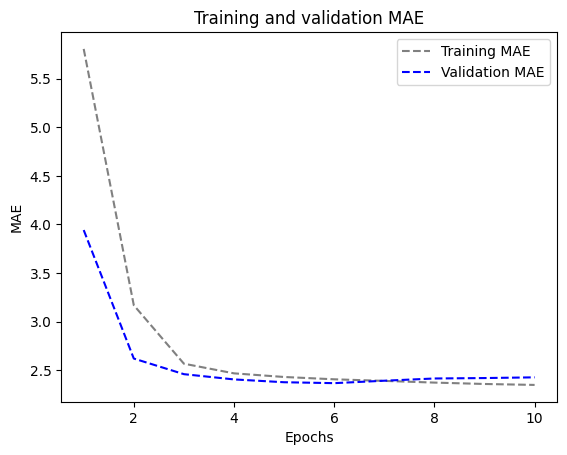

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **5.LSTM - dropout-regularized, stacked model**

In [35]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 336s 402ms/step - loss: 68.7284 - mae: 6.3336 - val_loss: 30.9591 - val_mae: 4.1179
Epoch 2/10
819/819 [==============================] - 324s 395ms/step - loss: 30.4947 - mae: 4.1293 - val_loss: 12.9479 - val_mae: 2.6819
Epoch 3/10
819/819 [==============================] - 326s 398ms/step - loss: 24.2025 - mae: 3.7232 - val_loss: 10.7197 - val_mae: 2.4962
Epoch 4/10
819/819 [==============================] - 327s 399ms/step - loss: 22.2766 - mae: 3.5823 - val_loss: 10.2495 - val_mae: 2.4652
Epoch 5/10
819/819 [==============================] - 324s 394ms/step - loss: 21.1347 - mae: 3.4947 - val_loss: 9.9270 - val_mae: 2.4336
Epoch 6/10
819/819 [==============================] - 328s 400ms/step - loss: 20.0937 - mae: 3.4109 - val_loss: 9.6757 - val_mae: 2.4097
Epoch 7/10
819/819 [==============================] - 329s 402ms/step - loss: 19.4228 - mae: 3.3560 - val_loss: 9.4835 - val_mae: 2.3927
Epoch 8/10
819/819 [=================

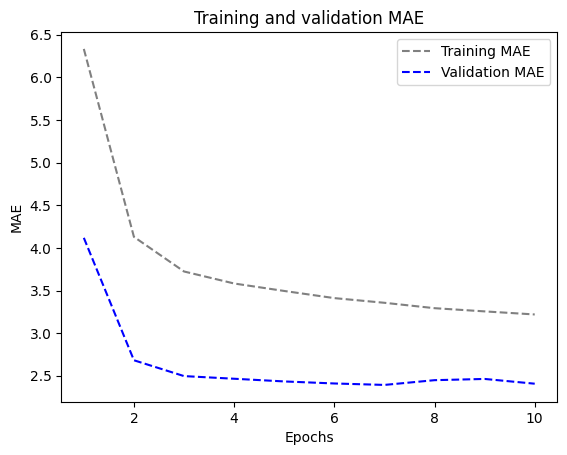

In [36]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **Bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 202s 241ms/step - loss: 26.3641 - mae: 3.6885 - val_loss: 10.2919 - val_mae: 2.4845
Epoch 2/10
819/819 [==============================] - 196s 239ms/step - loss: 9.2097 - mae: 2.3627 - val_loss: 9.6922 - val_mae: 2.4011
Epoch 3/10
819/819 [==============================] - 195s 238ms/step - loss: 8.3198 - mae: 2.2426 - val_loss: 9.7755 - val_mae: 2.4130
Epoch 4/10
819/819 [==============================] - 192s 234ms/step - loss: 7.7366 - mae: 2.1645 - val_loss: 10.3654 - val_mae: 2.4946
Epoch 5/10
819/819 [==============================] - 197s 241ms/step - loss: 7.3091 - mae: 2.1069 - val_loss: 10.9001 - val_mae: 2.5412
Epoch 6/10
819/819 [==============================] - 198s 241ms/step - loss: 6.9763 - mae: 2.0592 - val_loss: 10.6735 - val_mae: 2.5299
Epoch 7/10
819/819 [==============================] - 199s 243ms/step - loss: 6.7470 - mae: 2.0245 - val_loss: 10.4564 - val_mae: 2.5155
Epoch 8/10
819/819 [======================

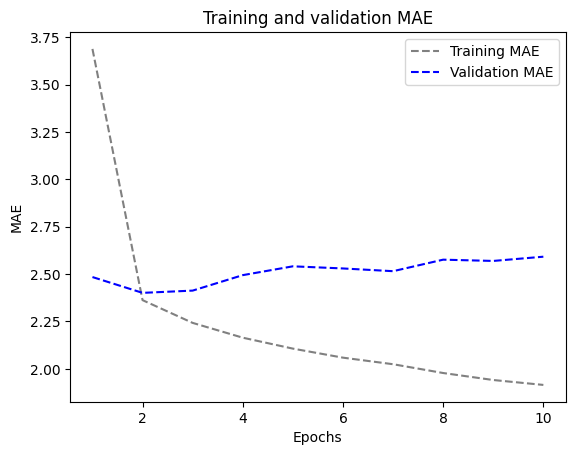

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [39]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 160s 190ms/step - loss: 47.0067 - mae: 5.1164 - val_loss: 25.6897 - val_mae: 3.9268
Epoch 2/10
819/819 [==============================] - 157s 191ms/step - loss: 17.5193 - mae: 3.2278 - val_loss: 22.5393 - val_mae: 3.7302
Epoch 3/10
819/819 [==============================] - 154s 188ms/step - loss: 14.5000 - mae: 2.9483 - val_loss: 22.4321 - val_mae: 3.7496
Epoch 4/10
819/819 [==============================] - 139s 169ms/step - loss: 12.8962 - mae: 2.7774 - val_loss: 22.3309 - val_mae: 3.7909
Epoch 5/10
819/819 [==============================] - 141s 171ms/step - loss: 11.7287 - mae: 2.6417 - val_loss: 22.9229 - val_mae: 3.7334
Epoch 6/10
819/819 [==============================] - 156s 190ms/step - loss: 10.8896 - mae: 2.5404 - val_loss: 21.8569 - val_mae: 3.6973
Epoch 7/10
819/819 [==============================] - 154s 188ms/step - loss: 10.1345 - mae: 2.4467 - val_loss: 23.0641 - val_mae: 3.7709
Epoch 8/10
819/819 [==============

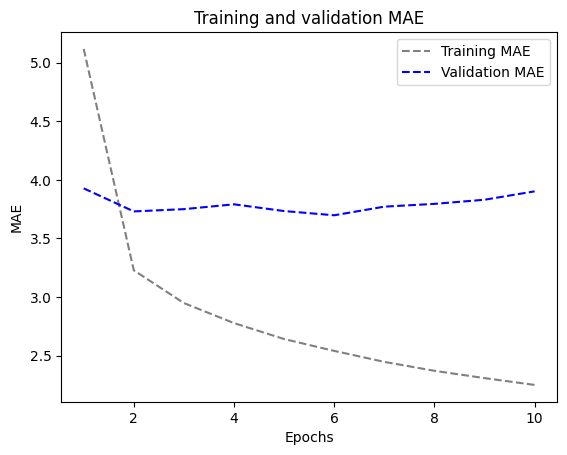

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built **14** models: Following are the details;

**Model 1:** common-sense, non-machine-learning baseline

**Model 2:** A basic machine-learning model

**Model 3:** 1D convolutional model

**Model 4:** Simple RNN layer that can process sequences of any length

**Model 5:** Simple RNN - Stacking RNN layers

**Model 6:** A Simple GRU (Gated Recurrent Unit)

**Model 7:** LSTM-Simple

**Model 8:** LSTM - dropout Regularization

**Model 9:** Stacked setup with 16 units

**Model 10:** Stacked setup with 32 units

**Model 11:** Stacked setup with 8 units

**Model 12:** LSTM - dropout-regularized, stacked

**Model 13:** Bidirectional LSTM

**Model 14:** 1D Convnets and LSTM togther

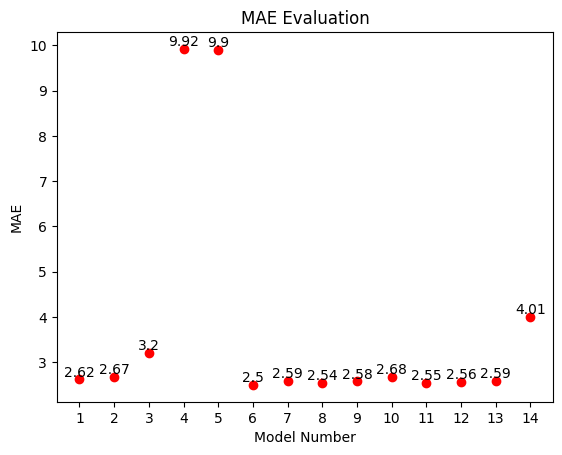

In [41]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

